# Collaborative Filtering with R

### Using library; [recommenderlab](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cran.r-project.org/web/packages/recommenderlab/recommenderlab.pdf).

In [1]:
install.packages("recommenderlab")
library(recommenderlab)


  利用できるバイナリー版がありますがソース版は後者です:
               binary source needs_compilation
recommenderlab  1.0.3  1.0.4             FALSE



 ソースパッケージ 'recommenderlab' をインストール中です 


 要求されたパッケージ Matrix をロード中です 

Warning message:
" パッケージ 'Matrix' はバージョン 4.1.3 の R の下で造られました "
 要求されたパッケージ arules をロード中です 

Warning message:
" パッケージ 'arules' はバージョン 4.1.3 の R の下で造られました "

 次のパッケージを付け加えます: 'arules' 


 以下のオブジェクトは 'package:base' からマスクされています: 

     abbreviate, write 


 要求されたパッケージ proxy をロード中です 

Warning message:
" パッケージ 'proxy' はバージョン 4.1.3 の R の下で造られました "

 次のパッケージを付け加えます: 'proxy' 


 以下のオブジェクトは 'package:Matrix' からマスクされています: 

     as.matrix 


 以下のオブジェクトは 'package:stats' からマスクされています: 

     as.dist, dist 


 以下のオブジェクトは 'package:base' からマスクされています: 

     as.matrix 


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



###  Preprocessing libraries.

In [2]:
library(tidyverse)
library(magrittr)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x tidyr::pack()   masks Matrix::pack()
x dplyr::recode() masks arules::recode()
x tidyr::unpack() masks Matrix::unpack()


 次のパッケージを付け加えます: 'magrittr' 


 以下のオブジェクトは 'package:purrr' からマスクされています: 

     set_names 


 以下のオブジェクトは 'package:tidyr' からマスクされています: 

     extract 




### Load sample data; [MovieLense](https://grouplens.org/datasets/movielens/).

In [3]:
data("MovieLense")

In [4]:
class(MovieLense)

[1] "realRatingMatrix"
attr(,"package")
[1] "recommenderlab"

### Convert data type into explanation; matrix.

In [5]:
MovieLense.mtx <- as(MovieLense, 'matrix') %>%
                    print

    Toy Story (1995) GoldenEye (1995) Four Rooms (1995) Get Shorty (1995)
1                  5                3                 4                 3
2                  4               NA                NA                NA
3                 NA               NA                NA                NA
4                 NA               NA                NA                NA
5                  4                3                NA                NA
6                  4               NA                NA                NA
7                 NA               NA                NA                 5
8                 NA               NA                NA                NA
9                 NA               NA                NA                NA
10                 4               NA                NA                 4
11                NA               NA                NA                NA
12                NA               NA                NA                 5
13                 3                3 

### Check number of lines and parallels.

In [6]:
dim(MovieLense.mtx) %>%
                print

[1]  943 1664


### Check head structure.

In [7]:
head(MovieLense.mtx[,1:10])

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995)
1,5,3,4,3,3,5,4,1,5,3
2,4,NA,NA,NA,NA,NA,NA,NA,NA,2
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,4,3,NA,NA,NA,NA,NA,NA,NA,NA
6,4,NA,NA,NA,NA,NA,2,4,4,NA


### Plot outline.

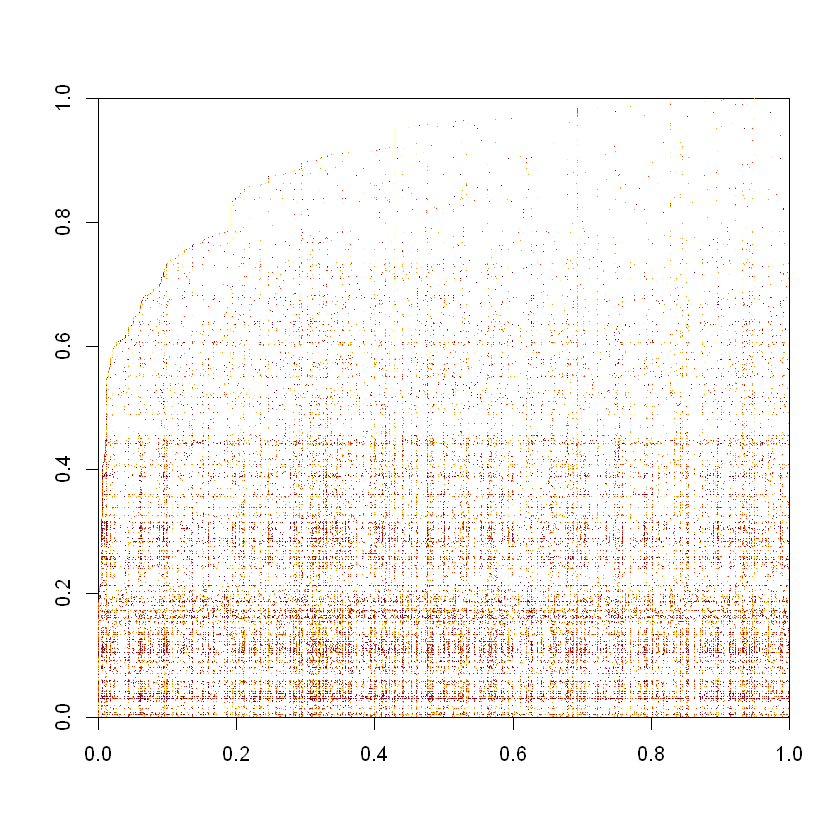

In [8]:
image(MovieLense.mtx)

### Check distribution of evaluations per person.

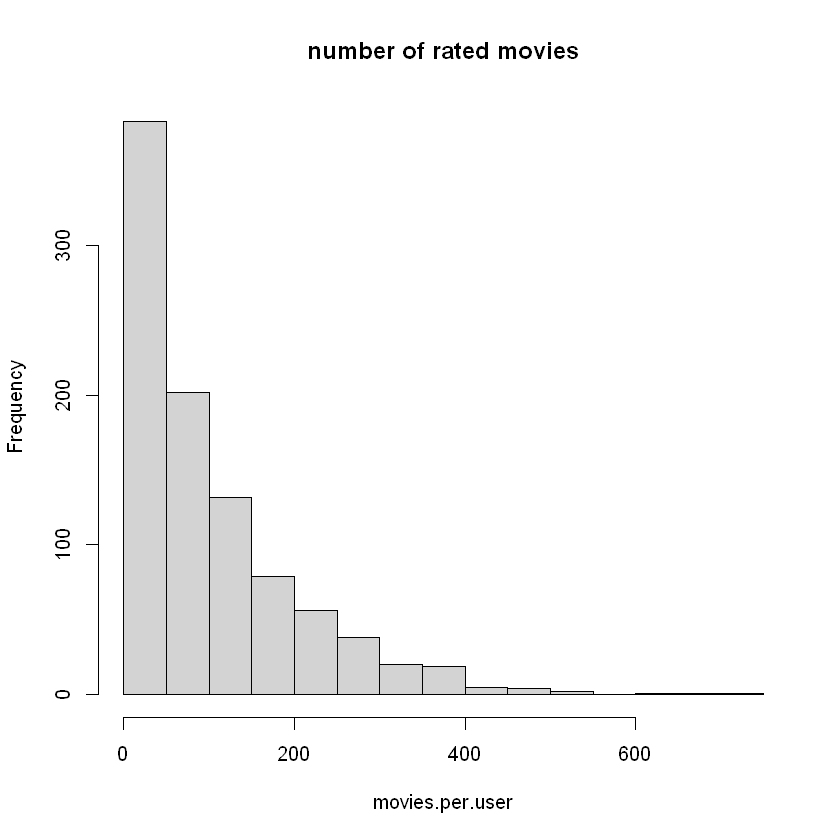

In [9]:
movies.per.user <- apply(!is.na(MovieLense.mtx), 1, sum)
hist(movies.per.user, main='number of rated movies')

### Utilize the data of 1st to 100th users as training data.

In [10]:
train <- MovieLense[1:100]

### Run user-based collaborative filtering.

In [11]:
rec <- Recommender(train, method = "UBCF")

### Check estimated valuations.

In [12]:
pred.ratings <- predict(rec, MovieLense[101], type='ratings')

### Extract top 10 highest rated values.

In [13]:
pred.ratings.topN <- head(sort(as(pred.ratings, 'list')[['101']],
  decreasing=TRUE), n=10)

### Visualize the result.

In [14]:
as.data.frame(pred.ratings.topN)

<0 x 0 matrix>

### Calculate cosine similarity of 2 vectors.

In [15]:
simil.cosine <- function(X, Y=NULL) {
  if (is.null(Y)) Y <- X
  nume <- X %*% t(Y)
  deno <- sqrt(diag(X %*% t(X)) %*%
          t(diag(Y %*% t(Y))))
  return(nume / deno)
}

### Centralize the evaluation values.

In [16]:
centering.by.user <- function(X) {
    center <- rowMeans(X, na.rm=TRUE)
    X.norm <- X - center
    return(list(data=X.norm, center=center))
}

### Obtain top k users by high similarity.

In [17]:
get.knn <- function(simil, k=25) {
  knn <- head(colnames(simil)[order(simil, decreasing=TRUE)], n=k)  
  knn.mtx <- matrix(knn, ncol=length(knn),
                    dimnames=list(rownames(simil), 1:k))
  return(knn.mtx)
}

### Function to calculate the weighted average.

In [18]:
mean.weighted <- function(target.id) {
  target.nn <- nn[target.id,]
  weighted.rating <- simil.mtx[target.id, target.nn, drop=TRUE] *
              train.cen[target.nn, ]
  mean.rating <- colSums(weighted.rating) /
              sum(simil.mtx[target.id, target.nn])
  return(mean.rating)
}

### Specify target users for recommendation.

In [19]:
target.id <- '101'

### Store evaluation values for training users and recommendation target users into variables.

In [20]:
train.mtx <- as(MovieLense[1:100], 'matrix')
target.mtx <- as(MovieLense[target.id], 'matrix')

### Centralize the evaluation value and extract it.

In [21]:
train.cen.obj <- centering.by.user(train.mtx)
target.cen.obj <- centering.by.user(target.mtx)
train.cen <- train.cen.obj$data
target.cen <- target.cen.obj$data

### Convert NA into 0. 

In [22]:
train.cen[is.na(train.cen)] <- .0
target.cen[is.na(target.cen)] <- .0

### Run the function; simil.cosine.

In [23]:
simil.mtx <- simil.cosine(target.cen, train.cen)

### Extract the top 25 most similar user numbers.

In [24]:
nn <- get.knn(simil.mtx, k=25)

### Calculate weighted average evaluation value and add back in average value.

In [25]:
weighted.mean.ratings <- mean.weighted(target.id)
pred.ratings <- target.cen.obj$center + weighted.mean.ratings

### Display top N list of unassessed evaluated values.

In [26]:
pred.not.rated <- pred.ratings[is.na(target.mtx)]
head(sort(pred.not.rated, decreasing=TRUE), n=10)

Shawshank Redemption, The (1994) 
                                 3.488621 
                             Fargo (1996) 
                                 3.450421 
           Raiders of the Lost Ark (1981) 
                                 3.449037 
                           Titanic (1997) 
                                 3.353159 
Indiana Jones and the Last Crusade (1989) 
                                 3.349170 
                Back to the Future (1985) 
                                 3.287979 
                           Contact (1997) 
                                 3.286931 
          Empire Strikes Back, The (1980) 
                                 3.284206 
                        Braveheart (1995) 
                                 3.224034 
               Princess Bride, The (1987) 
                                 3.209573

## [Reference](https://blog.brainpad.co.jp/entry/2017/05/23/153000)

# EOF